In [1]:
# Use SGD_TC to find minimum energy state of Ising spin glass model

import ObjectiveFunction as of
import helper_funcs as hf
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.nn.functional import dropout
import plotly
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm
import itertools
import importlib
import copy
from ADAM_TC import ADAM_TC
import adaptive_algos as aa

seed = 1

In [2]:
class IsingInteractionMatrix(Dataset):
    """
    Matrix of left/up interactions in 2D Ising model. 
    """
    def __init__(self, seed, N, sv, sh, special=False):

        torch.manual_seed(seed)
        np.random.seed(seed)
        self.N = N

        up_ints = torch.zeros((N,N))
        left_ints = torch.zeros((N,N))

        # Free BCs - either boundary int or neighbours set to 0 (we do both)
        up_ints[1:N,:] = torch.tensor(np.random.rand(N-1,N) * sv)
        left_ints[:,1:N] = torch.tensor(np.random.rand(N,N-1) * sh)
        
        # Create special square
        if special:
            up_ints[4*N//10:5*N//10, 4*N//10:5*N//10] = -1000
            left_ints[4*N//10:5*N//10, 4*N//10:5*N//10] = -1000

        self.left_ints = left_ints
        self.up_ints = up_ints
        self.data = self.generate_grid(seed)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):        
        select_left_ints = torch.zeros((self.N,self.N))
        select_up_ints = torch.zeros((self.N,self.N))
        grid_point = self.data[idx]

        select_left_ints[grid_point] = self.left_ints[grid_point]
        select_up_ints[grid_point] = self.up_ints[grid_point]
        
        return select_left_ints, select_up_ints

    def generate_grid(self, seed):
        
        random.seed(seed)
        x = np.arange(0, self.N)
        grid = list(itertools.product(x, x))
        random.shuffle(grid)
        
        return grid
    
    def partition_intmatrices(batch):
        
        left_int = batch[0].sum(dim=0)
        up_int = batch[1].sum(dim=0)

        return left_int, up_int


def cyclic_loader(dataloader):
    while True:
        for data in dataloader:
            yield data

In [3]:
class IsingHamiltonian(nn.Module):
    def __init__(self, seed, N):
        super().__init__()
        np.random.seed(seed)
        spins = torch.tensor(np.random.choice([-1, 1], (N,N)), dtype=torch.float64)
        self.spins = nn.Parameter(spins)
        self.N = N
    
    def forward(self, int_matrices, spins=None):
        """
        Computes average energy over spin state given interaction matrices.
        """
        
        if spins is None:
            spins = self.spins
        
        spin_copy = self.spins.detach().clone()
        left_ints, up_ints = int_matrices
        left_neighbours = spins.roll(1, dims=1)
        left_neighbours[:,0] = 0
        up_neighbours = spins.roll(1, dims=0)
        up_neighbours[0,:] = 0
        energy = -(spins * left_neighbours * left_ints + spins * up_neighbours * up_ints).sum(dim=(0,1))

        return energy
    
    def get_grads(self):
        res = []
        for p in self.parameters():
            if p.requires_grad:
                res.append(p.grad.view(-1))
        grad_flat = torch.cat(res)
        
        return grad_flat

In [8]:
frame_count = 200
seed = 69
N = 100
dataset = IsingInteractionMatrix(seed=seed, N=N, sv=1, sh=1, special=True)
batchsize = 500 # super small batchsize does not work
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batchsize, shuffle=False)
train_cdl = cyclic_loader(dataloader)

max_iterations = 1000
snapshot_rate = max_iterations/frame_count
opt_params = {'lr':1.0}

model = IsingHamiltonian(seed, N)
opt = torch.optim.SGD(params=model.parameters(), **opt_params)

mean_energies, spins = [], []
full_energy = model((dataset.left_ints, dataset.up_ints))
mean_energy = float(full_energy)/N**2
mean_energies.append(mean_energy)
spins.append(list(model.parameters())[0].detach().clone().numpy())
pbar = tqdm(range(max_iterations))

for i in pbar:
    model.train()
    batch = next(train_cdl)
    int_matrices = IsingInteractionMatrix.partition_intmatrices(batch)
    opt.zero_grad()
    energy = model(int_matrices=int_matrices)
    energy.backward()

    # Work around since torch.sign gives backprop grad of 0
    new_spins = torch.sign(model.spins - opt_params['lr']*model.spins.grad).detach()
    model.spins = nn.Parameter(new_spins)
    
    opt.zero_grad()
    full_energy = model((dataset.left_ints, dataset.up_ints))
    mean_energy = float(full_energy)/N**2
    mean_energies.append(mean_energy)
    
    if i % snapshot_rate == 0:
        spins.append(list(model.parameters())[0].detach().clone().numpy())

    pbar.set_description(f'Epoch {i}: {mean_energy}')

mean_energies = np.array(mean_energies)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
px.scatter(mean_energies)

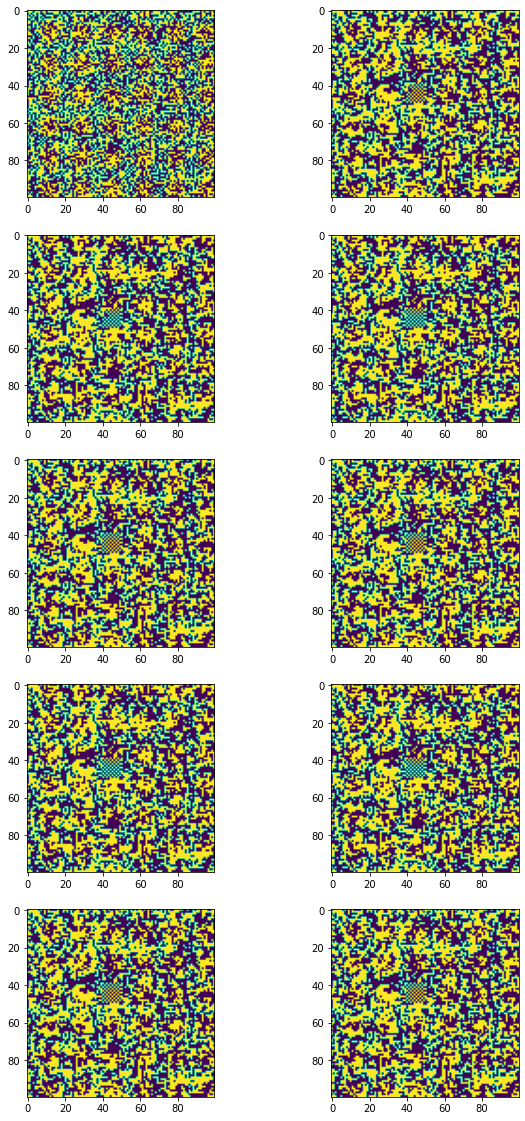

In [10]:
fig, ax = plt.subplots(5, 2, figsize=(10,20))
skip = frame_count//10
for i in range(5):
    for j in range(2):
        ax[i][j].imshow(spins[(i+j)*skip])

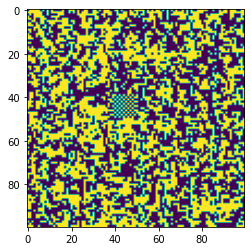

In [13]:
fig, ax = plt.subplots()

def init_func():
    ax.clear()

def update_plot(i):
    ax.imshow(spins[i])

anim = FuncAnimation(fig,
                     func=update_plot,
                     frames=range(0,len(spins)//4),
                     init_func=init_func,
                     interval=100)
anim.save('sgd_isingmodel_2d.mp4', dpi=150, fps=30, writer='ffmpeg')

In [93]:
################################# Apply SGD_TC ###############################
importlib.reload(aa)
frame_count = 200
seed = 69
N = 100
dataset = IsingInteractionMatrix(seed=seed, N=N, sv=1, sh=1, special=True)
batchsize = 500 # super small batchsize does not work
dataloader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batchsize, shuffle=False)
train_cdl = cyclic_loader(dataloader)

max_iterations = 1000
snapshot_rate = max_iterations/frame_count

# SGD_TC Params
lr = 1.0
height = 1.0
width = 50
max_iterations = 1000
scale_annealer = lambda progress: (1 - progress)**2.5
opt_params={'lr': lr, 'height': height, 'width': width, 'n_epochs': max_iterations, 
            'scale_annealer': scale_annealer}

model = IsingHamiltonian(seed, N)
opt = aa.SGD_TC(params=model.parameters(), func=model, **opt_params)

mean_energies, spins = [], []
full_energy = model((dataset.left_ints, dataset.up_ints))
mean_energy = float(full_energy)/N**2
mean_energies.append(mean_energy)
spins.append(list(model.parameters())[0].detach().clone().numpy())
pbar = tqdm(range(max_iterations))

ratios = []

for i in pbar:
    model.train()
    batch = next(train_cdl)
    int_matrices = IsingInteractionMatrix.partition_intmatrices(batch)
    opt.zero_grad()
    energy = model(int_matrices=int_matrices)
    energy.backward()
    # Work around since we can't use opt.step() normally - same reason as sgd
    opt.step(ising=True)
    lr = opt.scale_annealer(opt.step_count/opt.n_epochs) * opt_params['lr']
    new_spins = (model.spins - lr*model.spins.grad).detach()
    alpha = opt.adapt_alpha(new_spins, param_idx=0)
    levy_noise_vector = opt.levy_noise(new_spins, alpha, model.spins.grad, lr)
    ratio = float(model.spins.grad.norm()/levy_noise_vector.norm())
    new_spins = torch.sign(new_spins + lr*levy_noise_vector)
    model.spins = nn.Parameter(new_spins)
    
    opt.zero_grad()
    full_energy = model((dataset.left_ints, dataset.up_ints))
    mean_energy = float(full_energy)/N**2
    mean_energies.append(mean_energy)
    ratios.append(ratio)
    
    if i % snapshot_rate == 0:
        spins.append(list(model.parameters())[0].detach().clone().numpy())

    pbar.set_description(f'Epoch {i}: {mean_energy}')

mean_energies = np.array(mean_energies)
ratios = np.array(ratios)

  0%|          | 0/1000 [00:00<?, ?it/s]

ratio 0.5849370683043204 0.9975018746874609 tensor(4730.0569, dtype=torch.float64)
ratio 0.6896793498007231 0.9950074974993747 tensor(2294.2705, dtype=torch.float64)
ratio 2.6775413321059616 0.9925168665593331 tensor(2624.4941, dtype=torch.float64)
ratio 1.1426416674931217 0.990029979989988 tensor(1792.2752, dtype=torch.float64)
ratio 2.6340002271983307 0.9875468359130493 tensor(2224.7256, dtype=torch.float64)
ratio 0.2768039743063992 0.9850674324492836 tensor(1934.3365, dtype=torch.float64)
ratio 1.2870030511056785 0.9825917677185134 tensor(1897.1986, dtype=torch.float64)
ratio 0.312898542704616 0.9801198398396147 tensor(2330.7102, dtype=torch.float64)
ratio 0.7057561162814582 0.9776516469305163 tensor(3884.4246, dtype=torch.float64)
ratio 1.0826471467020067 0.9751871871081982 tensor(2276.9870, dtype=torch.float64)
ratio 0.5216983745889452 0.9727264584886899 tensor(1297.9504, dtype=torch.float64)
ratio 0.0973738073791613 0.9702694591870693 tensor(2861.2671, dtype=torch.float64)
ratio 

In [94]:
px.scatter(mean_energies)

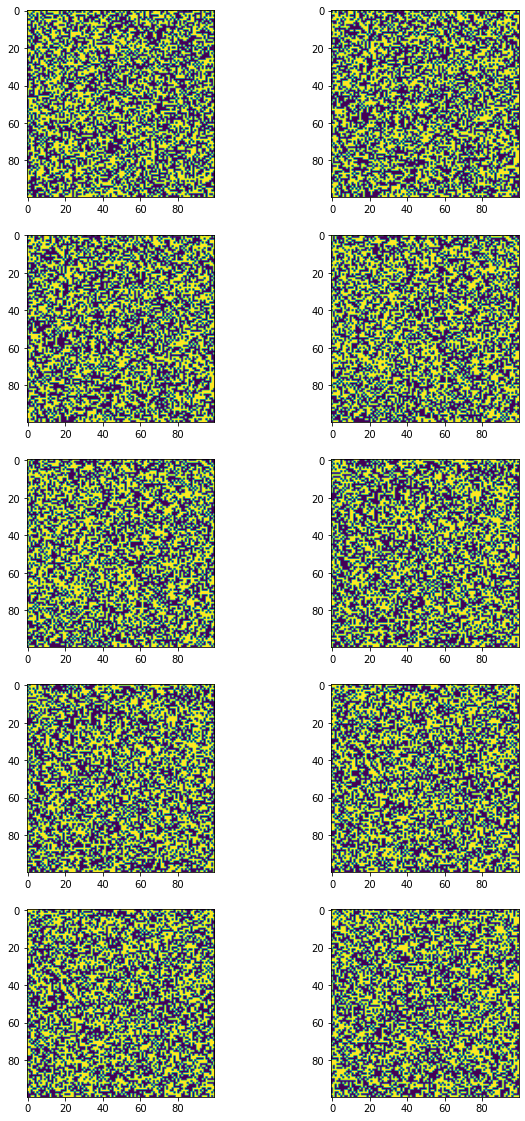

In [95]:
fig, ax = plt.subplots(5, 2, figsize=(10,20))
skip = frame_count//10
for i in range(5):
    for j in range(2):
        ax[i][j].imshow(spins[(i+j)*skip])

In [96]:
px.scatter(opt.alpha_record)

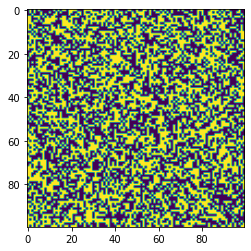

In [97]:
fig, ax = plt.subplots()

def init_func():
    ax.clear()

def update_plot(i):
    ax.imshow(spins[i])

anim = FuncAnimation(fig,
                     func=update_plot,
                     frames=range(0,len(spins)//4),
                     init_func=init_func,
                     interval=100)
anim.save('sgd_isingmodel_2d.mp4', dpi=150, fps=30, writer='ffmpeg')

In [90]:
######################## Simulated Annealing #########################
importlib.reload(aa)
frame_count = 200
seed = 69
N = 100
dataset = IsingInteractionMatrix(seed=seed, N=N, sv=1, sh=1, special=True)

max_iterations = 10000
snapshot_rate = max_iterations/frame_count

# SGD_TC Params
beta = 0.25
betas = []
for timestep in range(max_iterations):
    if timestep % 500 == 0:
        beta = beta * 1.1
    betas.append(beta)
opt_params={'n_epochs': max_iterations, 'betas': betas}

model = IsingHamiltonian(seed, N)
opt = aa.SimulatedAnnealing(params=model.parameters(), func=model, 
                            **opt_params)

mean_energies, spins = [], []
full_energy = model((dataset.left_ints, dataset.up_ints))
mean_energy = float(full_energy)/N**2
mean_energies.append(mean_energy)
spins.append(list(model.parameters())[0].detach().clone().numpy())
pbar = tqdm(range(max_iterations))

for i in pbar:
    model.train()
    int_matrices = (dataset.left_ints, dataset.up_ints)
    opt.zero_grad()
    energy = model(int_matrices=int_matrices)
    energy.backward()
    opt.step(int_matrices, float(energy))
    
    if i % snapshot_rate == 0:
        spins.append(list(model.parameters())[0].detach().clone().numpy())
    mean_energy = float(energy)/N**2
    mean_energies.append(mean_energy)
    pbar.set_description(f'Epoch {i}: {mean_energy}')

mean_energies = np.array(mean_energies)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [91]:
px.scatter(mean_energies)

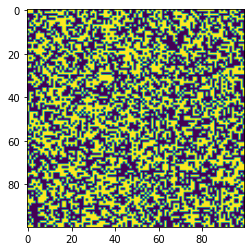

In [92]:
fig, ax = plt.subplots()

def init_func():
    ax.clear()

def update_plot(i):
    ax.imshow(spins[i])

anim = FuncAnimation(fig,
                     func=update_plot,
                     frames=range(0,len(spins)//4),
                     init_func=init_func,
                     interval=100)
anim.save('SA_isingmodel_2d.mp4', dpi=150, fps=30, writer='ffmpeg')

In [26]:
# Control test (using manual SGD)

def ising_model_simulation(N, seed, sh, sv, max_iterations):

    np.random.seed(seed)
    spins = torch.tensor(np.random.choice([-1, 1], (N,N)), 
                        dtype=torch.float64, requires_grad=True)
    initial_spins = spins.detach().clone()
    up_ints = torch.zeros((N,N))
    left_ints = torch.zeros((N,N))

    # Free BCs - either boundary int or neighbours set to 0 (we do both)
    up_ints[1:N,:] = torch.tensor(np.random.rand(N-1,N) * sv)
    left_ints[:,1:N] = torch.tensor(np.random.rand(N,N-1) * sh)
    # Create special square
    up_ints[4*N//10:5*N//10, 4*N//10:5*N//10] = -1000
    left_ints[4*N//10:5*N//10, 4*N//10:5*N//10] = -1000

    mean_energies = []

    for i in tqdm(range(max_iterations)):
        energy = compute_energy_backprop(spins, left_ints, up_ints)
        mean_energies.append(float(energy)/N**2)
        # emulate SGD with dropout
        # make spins continuous, then discretise for plotting?
        # akin to collapsing wave function built by SGD?
        spins = torch.sign(dropout(-spins.grad, p=0.95) + spins).detach()
        spins.requires_grad = True
    
    return mean_energies, initial_spins, spins.detach()
                
def compute_energy_backprop(spins, left_ints, up_ints):
    # Computing energy - find neighbours, matrix dot product, then sum.

    left_neighbours = spins.roll(1, dims=1)
    left_neighbours[:,0] = 0
    up_neighbours = spins.roll(1, dims=0)
    up_neighbours[0,:] = 0
    energy = -(spins * left_neighbours * left_ints + spins * up_neighbours * up_ints).sum(dim=(0,1))
    energy.backward() # gradients stored in spins.grad
    return energy


In [27]:
mean_energies, initial_spins, spins = ising_model_simulation(100, 0, 1, 1, 1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

-13.30496207797709


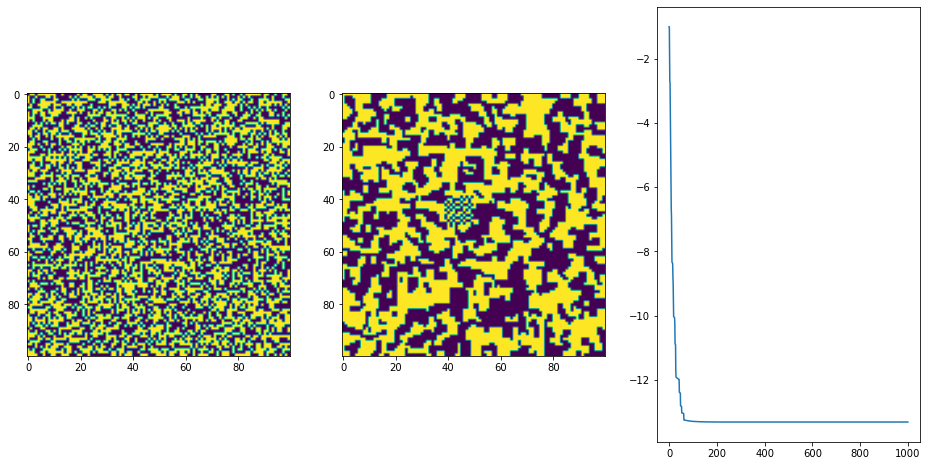

In [28]:
fig, ax = plt.subplots(1,3, figsize=(16, 8))
ax[0].imshow(initial_spins)
ax[1].imshow(spins)
ax[2].plot(mean_energies)
print(mean_energies[-1])

In [ ]:
########################### Development code below ###################################

In [2]:
# Initialize interaction array - defines dataset
# free parameters are the spins configs
np.random.seed(0)
sh, sv = 1, 1
N = 100
spins = torch.tensor(np.random.choice([-1, 1], (N,N)), 
                     dtype=torch.float64, requires_grad=True)
up_ints = torch.zeros((N,N))
left_ints = torch.zeros((N,N))

# Free BCs - either boundary int or neighbours set to 0 (we do both)
up_ints[1:N,:] = torch.tensor(np.random.rand(N-1,N) * sv)
left_ints[:,1:N] = torch.tensor(np.random.rand(N,N-1) * sh)
up_ints[4*N//10:5*N//10, 4*N//10:5*N//10] = 1000
left_ints[4*N//10:5*N//10, 4*N//10:5*N//10] = 1000

# Computing energy - find neighbours, matrix dot product, then sum
left_neighbours = spins.roll(1, dims=1)
left_neighbours[:,0] = 0
up_neighbours = spins.roll(1, dims=0)
up_neighbours[0,:] = 0
energy = -(spins * left_neighbours * left_ints + spins * up_neighbours * up_ints).sum(dim=(0,1))
energy.backward()
energy


tensor(-10078.5151, dtype=torch.float64, grad_fn=<NegBackward0>)

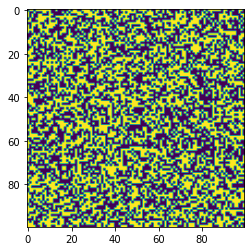

In [3]:
plt.imshow(spins.detach().numpy())

In [4]:
new_spins = torch.sign(dropout(-spins.grad, p=0.8) + spins).detach()
new_spins.requires_grad = True
#new_spins = torch.sign(-spins.grad + spins)
# diff_map = torch.abs(new_spins.detach() - spins.detach())
# plt.imshow(diff_map.numpy())

In [41]:
left_neighbours = new_spins.roll(1, dims=1)
left_neighbours[:,0] = 0
up_neighbours = new_spins.roll(1, dims=0)
up_neighbours[0,:] = 0
new_energy = -(new_spins * left_neighbours * left_ints + new_spins * up_neighbours * up_ints).sum(dim=(0,1))
new_energy.backward()
new_energy

tensor(-120862.7138, dtype=torch.float64, grad_fn=<NegBackward0>)

In [42]:
spins = new_spins

In [43]:
#new_spins = torch.sign(dropout(-spins.grad, p=0.8) + spins).detach()
new_spins = torch.sign(-spins.grad + spins).detach()
new_spins.requires_grad = True


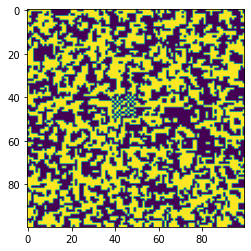

In [44]:
plt.imshow(new_spins.detach().numpy())

In [66]:
class IsingSpinGlass(Dataset):
    

IndentationError: expected an indented block (Temp/ipykernel_10872/3672341264.py, line 2)